In [267]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

# 1.将所有数据合并

## 1.1 数据读取

In [178]:
CentralPark_rental = pd.read_parquet("C:/Users\lenovo\Desktop\Python_HW\HW3/rental_data\CentralPark_rental_data_revised.parquet")
dazhulin_rental = pd.read_parquet('C:/Users\lenovo\Desktop\Python_HW\HW3/rental_data\dazhulin_rent.parquet')
konggang_rental = pd.read_parquet('C:/Users\lenovo\Desktop\Python_HW\HW3/rental_data\konggang_housing_rent.parquet')
longtousi_rental = pd.read_parquet('C:/Users\lenovo\Desktop\Python_HW\HW3/rental_data\Longtousi_rental_data_20pages(1).parquet')

In [180]:
CentralPark_sale = pd.read_parquet("C:/Users\lenovo\Desktop\Python_HW\HW3/sale_data\CentralPark_sale_data_revised.parquet")
dazhulin_sale = pd.read_parquet('C:/Users\lenovo\Desktop\Python_HW\HW3\sale_data\dazhulin_sale.parquet')
konggang_sale = pd.read_parquet("C:/Users\lenovo\Desktop\Python_HW\HW3\sale_data\konggang_housing_price.parquet")
longtousi_sale = pd.read_parquet("C:/Users\lenovo\Desktop\Python_HW\HW3\sale_data\Longtousi_sale_data_20pages(1).parquet")

### 1.1.1 中央公园

In [181]:
CentralPark_rental['Rent'] = CentralPark_rental['Rent'].astype(float)
CentralPark_rental['Area'] = CentralPark_rental['Area'].astype(float)
CentralPark_rental['rent/m2'] = CentralPark_rental['Rent'] / CentralPark_rental['Area']
CentralPark_rental['block'] = 'CentralPark'
CentralPark_rental_cleaned = CentralPark_rental[['Rent', 'Area', 'rent/m2', 'block']]

In [182]:
CentralPark_sale['Price'] = CentralPark_sale['Price'].astype(float)
CentralPark_sale['Area'] = CentralPark_sale['Area'].astype(float)
CentralPark_sale['price/m2'] = CentralPark_sale['Price'] / CentralPark_sale['Area']
CentralPark_sale['block'] = 'CentralPark'
CentralPark_sale_cleaned = CentralPark_sale[['Price', 'Area', 'price/m2', 'block']]

In [183]:
CentralPark_rental_cleaned.head()

,Rent,Area,rent/m2,block
0,2200.0,78.0,28.205128,CentralPark
1,2200.0,92.0,23.913043,CentralPark
2,2200.0,97.0,22.680412,CentralPark
3,2700.0,98.0,27.551020,CentralPark
4,3300.0,99.0,33.333333,CentralPark


In [184]:
CentralPark_sale_cleaned.head()

,Price,Area,price/m2,block
0,172.0,124.53,1.381193,CentralPark
1,189.0,150.00,1.260000,CentralPark
2,145.0,127.66,1.135830,CentralPark
3,113.8,97.03,1.172833,CentralPark
4,128.0,89.05,1.437395,CentralPark


In [185]:
CentralPark_sale_cleaned.head()

,Price,Area,price/m2,block
0,172.0,124.53,1.381193,CentralPark
1,189.0,150.00,1.260000,CentralPark
2,145.0,127.66,1.135830,CentralPark
3,113.8,97.03,1.172833,CentralPark
4,128.0,89.05,1.437395,CentralPark


### 1.1.2 大竹林

In [186]:
dazhulin_rental.head()

,标题,面积,月租金,每平米月租金,房屋信息
0,可免废停车 拎包即住 带大阳台 轻轨贰佰米 随时看房,94.0,2100.0,22.340426,整租|2室2厅|94㎡|朝东
1,龙湖熙溪地 精装2房 大外阳台 干净整洁 视野开阔,79.0,2500.0,31.645570,整租|2室2厅|79㎡|朝东北
2,渝北区 金科天元道砚北B组团E区 三房 2800元月,108.0,2800.0,25.925926,整租|3室2厅|108㎡|朝北
3,渝北区 江与城江城时光 二房,76.0,2200.0,28.947368,整租|2室2厅|76㎡|朝西北
4,大竹林慈竹苑 三房出租 精装修 随时看房下楼即轻轨,89.0,2100.0,23.595506,整租|3室2厅|89㎡|朝北


In [187]:
dazhulin_sale.head()

,标题,总价,单价,面积,房屋信息,地址,区域
0,高品质 壹号院 看中庭 出门即地铁 视野很好 诚心卖,3200000.0,19082.0,167.697306,4室2厅 | 167.7㎡ |中层 （共16层） | 东南向,重庆·融创壹号院\n大竹林,大竹林
1,"融创玻璃幕墙大平层,出则繁华,入则宁静。",4460000.0,26548.0,167.997589,4室2厅 | 168㎡ |中层 （共15层） | 南向,重庆·融创壹号院\n大竹林,大竹林
2,龙湖悠澜四房洋房 视野开阔无遮挡 看别墅 随时看房,2020000.0,14638.0,137.996994,4室2厅 | 138㎡ |中层 （共10层） | 南向,新江与城\n大竹林,大竹林
3,"外圈端户大花园 户型好,地下室全采光",6900000.0,20910.0,329.985653,板楼| 卧室：4个 | 无花园 | 330㎡ | 南向,新江与城天琅\n大竹林,大竹林
4,"临江低密度品质小区,龙湖品质物业",1000000.0,12424.0,80.489375,3室2厅 | 80.49㎡ |高层 （共32层） | 东南向,江与城江城时光\n大竹林,大竹林


In [188]:
dazhulin_rental = dazhulin_rental.rename(columns={'面积':'Area','月租金':'Rent'})
dazhulin_rental['rent/m2'] = dazhulin_rental['Rent']/dazhulin_rental['Area']
dazhulin_rental['block'] = 'dazhulin'
dazhulin_rental_cleaned = dazhulin_rental[['Rent', 'Area', 'rent/m2', 'block']]

In [189]:
dazhulin_sale = dazhulin_sale.rename(columns={'面积':'Area','总价':'Price'})
dazhulin_sale['Price'] = dazhulin_sale['Price'] / 10000
dazhulin_sale['price/m2'] = dazhulin_sale['Price']/dazhulin_sale['Area']
dazhulin_sale['block'] = 'dazhulin'
dazhulin_sale_cleaned = dazhulin_sale[['Price', 'Area', 'price/m2', 'block']]

In [190]:
dazhulin_rental_cleaned.head()

,Rent,Area,rent/m2,block
0,2100.0,94.0,22.340426,dazhulin
1,2500.0,79.0,31.645570,dazhulin
2,2800.0,108.0,25.925926,dazhulin
3,2200.0,76.0,28.947368,dazhulin
4,2100.0,89.0,23.595506,dazhulin


In [191]:
dazhulin_sale_cleaned.head()

,Price,Area,price/m2,block
0,320.0,167.697306,1.9082,dazhulin
1,446.0,167.997589,2.6548,dazhulin
2,202.0,137.996994,1.4638,dazhulin
3,690.0,329.985653,2.0910,dazhulin
4,100.0,80.489375,1.2424,dazhulin


### 1.1.3 空港

In [192]:
konggang_rental.head()

,标题,户型,面积（㎡）,朝向,位置,价格（元/月）,block
0,"两室两卫,拎包入住,轻轨站旁,随时看房!",2室2厅,37.0,朝南,渝北-空港-桥达茂宸广场,1300,空港
1,空港广场 三号线!江北机场!华夏航空!押一付一!!,2户合租,21.0,朝南,渝北-空港-瑞丰花苑,600,空港
2,渝北空港圣地 3室2厅 130.67㎡ 1600元/,3室2厅,130.0,朝北,渝北-空港-空港圣地,1600,空港
3,渝北空港阳光名城 6室3厅 283.2㎡ 2800元,6室3厅,283.0,朝南北,渝北-空港-阳光名城,2800,空港
4,渝北空港浩博天地105平方米 3室2厅2卫,3室2厅,105.0,朝南北,渝北-空港-浩博天地,1900,空港


In [193]:
konggang_sale.head()

,标题,户型,面积（㎡）,楼层,朝向,年份,户主,位置,价格（元）,block
0,国企期间价!3号线轻轨口 带车位 法式 洋房 全落地窗,3室2厅,90.00,低层（共8层）,南北向,2021年建,罗红,招商雍璟城空港 轻轨3号线莲花站,680000.0,空港
1,捡耙活!首钢洋房(精装修拎包入住)支持谈价(送车位)三号线旁,3室2厅,96.43,高层（共17层）,南向,2022年建,杨春林,首钢铂鹭风华空港 空港大道莲花站旁,670000.0,空港
2,新上!3号线轻轨口 带车位 法式 洋房 全落地窗 诚心出售,3室2厅,90.00,中层（共8层）,南北向,2021年建,黄雄,招商雍璟城空港 轻轨3号线莲花站,700000.0,空港
3,"(国庆降21万)首付9万买3房,送产权车位 送4万5家具家电",3室2厅,81.00,中层（共14层）,南向,2021年建,祝成佳,首钢铂鹭风华空港 空港大道莲花站旁,470000.0,空港
4,首付7万 到手40万买空港现房3房 送产权车位 送4万5家电,3室2厅,80.00,中层（共11层）,南北向,2022年建,祝成佳,首钢铂鹭风华空港 空港大道莲花站旁,480000.0,空港


In [194]:
konggang_rental = konggang_rental.rename(columns={'面积（㎡）':'Area', '价格（元/月）':'Rent'})
konggang_rental['Rent'] = konggang_rental['Rent'].astype(float)
konggang_rental['rent/m2'] = konggang_rental['Rent']/konggang_rental['Area']
konggang_rental['block'] = 'konggang'
konggang_rental_cleaned = konggang_rental[['Rent','Area','rent/m2', 'block']]

In [195]:
konggang_sale = konggang_sale.rename(columns={'面积（㎡）':'Area', '价格（元）':'Price'})
konggang_sale['Price'] = konggang_sale['Price'].astype(float)
konggang_sale['Price'] = konggang_sale['Price'] / 10000
konggang_sale['price/m2'] = konggang_sale['Price']/konggang_sale['Area']
konggang_sale['block'] = 'konggang'
konggang_sale_cleaned = konggang_sale[['Price','Area','price/m2', 'block']]

In [196]:
konggang_rental_cleaned.head()

,Rent,Area,rent/m2,block
0,1300.0,37.0,35.135135,konggang
1,600.0,21.0,28.571429,konggang
2,1600.0,130.0,12.307692,konggang
3,2800.0,283.0,9.893993,konggang
4,1900.0,105.0,18.095238,konggang


In [197]:
konggang_sale_cleaned.head()

,Price,Area,price/m2,block
0,68.0,90.00,0.755556,konggang
1,67.0,96.43,0.694805,konggang
2,70.0,90.00,0.777778,konggang
3,47.0,81.00,0.580247,konggang
4,48.0,80.00,0.600000,konggang


### 1.1.4 龙头寺

In [198]:
longtousi_rental.head()

,Title,Area Info,Location,Subway Info,Rent,Area
0,渝北区 鲁能星城十一街区 二房,整租|2室2厅|83㎡|朝南,渝北-龙头寺-鲁能星城十一街区,距环线渝鲁站约515米。,2300,83
1,渝北区 鲁能星城一街区 二房 1700元/月,整租|2室2厅|83㎡|朝东,渝北-龙头寺-鲁能星城一街区,距环线渝鲁站约290米。,1700,83
2,渝北区 鲁能星城六街区 三房 1800元/月,整租|3室2厅|101㎡|朝东,渝北-龙头寺-鲁能星城六街区,距环线渝鲁站约753米。,1800,101
3,渝北区 鲁能星城八街区 三房 2400元/月,整租|3室2厅|117㎡|朝南,渝北-龙头寺-鲁能星城八街区,距环线渝鲁站约613米。,2400,117
4,渝北区 鲁能星城六街区业主自住精装二房 拎包入住 随,整租|2室2厅|86㎡|朝东南,渝北-龙头寺-鲁能星城六街区,距环线渝鲁站约753米。,2100,86


In [199]:
longtousi_sale.head()

,Title,Area Info,Location,Subway Info,Price,Area
0,liaopa 保利香槟花园D区 三房 106万,3室2厅 | 103.93㎡ |低层 （共18层） | 北向 | 2009年建 |邱朝阳,保利香槟花园D区\n龙头寺 渝北区玉兰路100号,距3号线狮子坪站约186米,106,103.93
1,肯定真实!免一试8蜀小一初制表 中间楼层 出门即公园和轻轨,2室2厅 | 87㎡ |中层 （共33层） | 东南向 | 2007年建 |胡丽,鲁能星城八街区\n龙头寺 渝北区渝鲁大道777号,距环线渝鲁站约613米,125,87
2,渝北区 鲁能星城八街区 全套 巴标 二房,2室2厅 | 88㎡ | 底层 （共29层） | 北向 | 2007年建 |黄雄,鲁能星城八街区\n龙头寺 渝北区渝鲁大道777号,距环线渝鲁站约613米,132,88
3,渝北区 保利香槟花园C区 三房 109万,3室2厅 | 105.03㎡ |中层 （共18层） | 北向 | 2008年建 |邱朝阳,保利香槟花园C区\n龙头寺 渝北区树兰路127号,距3号线狮子坪站约74米,109,105.03
4,保利香槟花园B区 精装3房 周边商圈发达 交通便利,3室2厅 | 102.91㎡ |中层 （共18层） | 东北向 | 2007年建 |邱朝阳,保利香槟花园B区\n龙头寺 渝北区树兰路125号,距3号线狮子坪站约166米,108,102.91


In [200]:
longtousi_rental['Rent'] = longtousi_rental['Rent'].astype(float)
longtousi_rental['Area'] = longtousi_rental['Area'].astype(float)
longtousi_rental['rent/m2'] = longtousi_rental['Rent'] / longtousi_rental['Area']
longtousi_rental['block'] = 'longtousi'
longtousi_rental_cleaned = longtousi_rental[['Rent', 'Area', 'rent/m2', 'block']]

In [201]:
longtousi_sale['Price'] = longtousi_sale['Price'].astype(float)
longtousi_sale['Area'] = longtousi_sale['Area'].astype(float)
longtousi_sale['price/m2'] = longtousi_sale['Price'] / longtousi_sale['Area']
longtousi_sale['block'] = 'longtousi'
longtousi_sale_cleaned = longtousi_sale[['Price', 'Area', 'price/m2', 'block']]

In [202]:
longtousi_rental_cleaned.head()

,Rent,Area,rent/m2,block
0,2300.0,83.0,27.710843,longtousi
1,1700.0,83.0,20.481928,longtousi
2,1800.0,101.0,17.821782,longtousi
3,2400.0,117.0,20.512821,longtousi
4,2100.0,86.0,24.418605,longtousi


In [203]:
longtousi_sale_cleaned.head()

,Price,Area,price/m2,block
0,106.0,103.93,1.019917,longtousi
1,125.0,87.00,1.436782,longtousi
2,132.0,88.00,1.500000,longtousi
3,109.0,105.03,1.037799,longtousi
4,108.0,102.91,1.049461,longtousi


## 1.2 数据合并(HW3-3 Q1)

In [204]:
rental_merged = pd.concat(
    [CentralPark_rental_cleaned,
     dazhulin_rental_cleaned,
     konggang_rental_cleaned,
     longtousi_rental_cleaned],
    ignore_index=True   # 重新编号行索引
)


In [205]:
sale_merged = pd.concat(
    [CentralPark_sale_cleaned,
     dazhulin_sale_cleaned,
     konggang_sale_cleaned,
     longtousi_sale_cleaned],
    ignore_index=True   # 重新编号行索引
)


# 2 数据分析

## 2.1(HW3-3 Q2) Data description for each block, any outliers?

##### Answer:通常，我们将远高于第三四分位数（75%）或远低于第一四分位数（25%）的值视为潜在异常值。一个常用的经验法则是，如果某个数据点与四分位距（IQR = Q3 - Q1）相差超过 1.5 * IQR，则可能是异常值。其中潜在异常值比例在租房市场普遍高于售房市场，售房市场在不同的区块潜在异常值都维持在3%左右。平均租金和平均售价都是大竹林最高，空港最低


In [271]:
# 定义异常值检测函数（IQR方法）
def detect_outliers_iqr(df, variable_name):
    """使用IQR方法检测异常值"""
    Q1 = df[variable_name].quantile(0.25)
    Q3 = df[variable_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[variable_name] < lower_bound) | (df[variable_name] > upper_bound)]
    return float(len(outliers) / len(df))

In [287]:
# 分析各区域异常值比例
for area in ['CentralPark', 'dazhulin', 'konggang', 'longtousi']:
    # 销售数据异常值比例
    sale_subset = sale_merged[sale_merged['block'] == area]
    price_outlier_ratio = detect_outliers_iqr(sale_subset, 'price/m2')
    print(f"price/m2 outlier percentage in {area}: {price_outlier_ratio*100:.2f}%")
    
    # 租赁数据异常值比例
    rental_subset = rental_merged[rental_merged['block'] == area]
    rent_outlier_ratio = detect_outliers_iqr(rental_subset, 'rent/m2')
    print(f"rent/m2 outlier percentage in {area}: {rent_outlier_ratio*100:.2f}%")
    
    print("-" * 50)  # 添加分隔线

price/m2 outlier percentage in CentralPark: 3.67%
rent/m2 outlier percentage in CentralPark: 1.50%
--------------------------------------------------
price/m2 outlier percentage in dazhulin: 3.42%
rent/m2 outlier percentage in dazhulin: 10.12%
--------------------------------------------------
price/m2 outlier percentage in konggang: 3.00%
rent/m2 outlier percentage in konggang: 6.21%
--------------------------------------------------
price/m2 outlier percentage in longtousi: 3.75%
rent/m2 outlier percentage in longtousi: 6.92%
--------------------------------------------------


In [206]:
#中央公园数据describe，rent单位为元
rental_merged[rental_merged['block'] == 'CentralPark'].describe()

,Rent,Area,rent/m2
count,1200.000000,1200.000000,1200.000000
mean,2376.223333,97.483333,24.879906
std,2026.217747,36.197651,11.113988
min,130.000000,23.000000,1.313131
25%,1500.000000,82.000000,17.045455
50%,2200.000000,96.000000,25.000000
75%,2800.000000,105.250000,30.864198
max,36000.000000,339.000000,106.194690


In [207]:
#单位为万元
sale_merged[sale_merged['block'] == 'CentralPark'].describe()

,Price,Area,price/m2
count,1200.000000,1200.000000,1200.000000
mean,220.533192,146.671700,1.428121
std,181.243506,84.363011,0.400478
min,24.000000,32.750000,0.405954
25%,128.000000,99.000000,1.177285
50%,162.500000,123.385000,1.397260
75%,230.250000,153.000000,1.589886
max,1860.000000,861.590000,6.259542


In [208]:
#大竹林
rental_merged[rental_merged['block'] == 'dazhulin'].describe()

,Rent,Area,rent/m2
count,415.000000,415.000000,415.000000
mean,4028.790361,125.354217,30.714387
std,3093.034233,54.906177,12.377262
min,650.000000,23.000000,5.200000
25%,2500.000000,92.000000,24.452438
50%,3000.000000,117.000000,29.166667
75%,4400.000000,143.000000,34.567901
max,20000.000000,500.000000,97.560976


In [210]:
#单位为万元
sale_merged[sale_merged['block'] == 'dazhulin'].describe()

,Price,Area,price/m2
count,1200.000000,1200.000000,1200.000000
mean,257.790750,144.774300,1.602363
std,318.941165,85.978879,0.504361
min,31.000000,35.998326,0.670300
25%,140.000000,99.779429,1.290700
50%,195.000000,132.733075,1.531850
75%,280.000000,152.714105,1.821625
max,4800.000000,863.979354,5.846200


In [211]:
#空港
rental_merged[rental_merged['block'] == 'konggang'].describe()

,Rent,Area,rent/m2
count,499.000000,499.000000,499.000000
mean,1512.224449,80.186373,20.765703
std,458.663658,32.570272,7.073000
min,600.000000,21.000000,6.818182
25%,1225.000000,57.000000,16.315439
50%,1500.000000,80.000000,19.277108
75%,1675.000000,98.000000,23.502907
max,5500.000000,300.000000,48.780488


In [212]:
#空港
sale_merged[sale_merged['block'] == 'konggang'].describe()

,Price,Area,price/m2
count,1200.000000,1199.000000,1199.000000
mean,71.752567,95.375004,0.745384
std,31.653601,36.392295,0.161237
min,18.500000,36.000000,0.333769
25%,53.000000,77.030000,0.633917
50%,67.750000,91.000000,0.730549
75%,85.000000,113.000000,0.824899
max,468.000000,864.540000,1.436575


In [213]:
#龙头寺
rental_merged[rental_merged['block'] == 'longtousi'].describe()

,Rent,Area,rent/m2
count,1200.000000,1200.000000,1200.000000
mean,2836.258333,101.440833,27.771423
std,3008.512457,56.550831,12.383555
min,600.000000,18.000000,5.603448
25%,2000.000000,80.000000,22.448980
50%,2300.000000,93.000000,25.000000
75%,2800.000000,116.000000,30.026882
max,35000.000000,600.000000,256.410256


In [214]:
sale_merged[sale_merged['block'] == 'longtousi'].describe()

,Price,Area,price/m2
count,1200.000000,1200.000000,1200.000000
mean,165.292875,118.091583,1.316977
std,141.798758,59.327158,0.365805
min,32.000000,27.000000,0.633987
25%,102.000000,86.710000,1.078372
50%,128.000000,102.760000,1.263736
75%,175.000000,130.000000,1.478198
max,1250.000000,593.000000,3.344801


In [ ]:
for area in ['CentralPark', 'dazhulin', 'konggang', 'longtousi']:
    print(f"price/m2 outlier percentage in {area}: {detect_outliers_iqr(sale_merged[sale_merged['block'] == area]['price/m2'], 'price/m2')['outlier_percentage']:.2f}%")
    print(f"rent/m2 outlier percentage in {area}: {detect_outliers_iqr(rental_merged[rental_merged['block'] == area]['rent/m2'], 'rent/m2')['outlier_percentage']:.2f}%")
    print("-" * 50)  # 添加分隔线

## 2.2(HW3-3 Q3(1)) Calculate median price to rent ratio for each block

In [215]:
rental_merged.head()

,Rent,Area,rent/m2,block
0,2200.0,78.0,28.205128,CentralPark
1,2200.0,92.0,23.913043,CentralPark
2,2200.0,97.0,22.680412,CentralPark
3,2700.0,98.0,27.551020,CentralPark
4,3300.0,99.0,33.333333,CentralPark


In [216]:
rental_median = rental_merged.groupby('block')['rent/m2'].median().reset_index()
price_median = sale_merged.groupby('block')['price/m2'].median().reset_index()

In [217]:
median = pd.merge(price_median, rental_median, on = ['block'])

In [218]:
median ['price/m2'] = median['price/m2']*10000
median ['price_to_rent'] = median['price/m2']/median['rent/m2']

In [219]:
median

,block,price/m2,rent/m2,price_to_rent
0,CentralPark,13972.602740,25.000000,558.904110
1,dazhulin,15318.500000,29.166667,525.205714
2,konggang,7305.491294,19.277108,378.972361
3,longtousi,12637.362637,25.000000,505.494505


## 2.3 Figure A（HW3-3 Q3(2): Bar Plot the median price to rent ratio for each block (The global fair value should around 200)

In [220]:
median

,block,price/m2,rent/m2,price_to_rent
0,CentralPark,13972.602740,25.000000,558.904110
1,dazhulin,15318.500000,29.166667,525.205714
2,konggang,7305.491294,19.277108,378.972361
3,longtousi,12637.362637,25.000000,505.494505


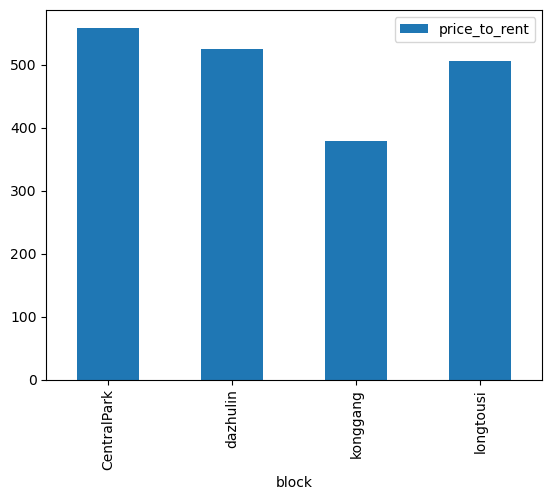

In [221]:
median.plot.bar(x='block', y='price_to_rent')
plt.show()

# 3 Data Science Model

## 3.1 linear model(HW3-4)

In [258]:
# === Step 1 准备数据 ===
sale = sale_merged.copy()
rental = rental_merged.copy()
sale['price/m2'] = sale['price/m2']*10000

# === Step 2 定义特征 ===
X_sale = sale[['Area','block']]
y_sale = sale['price/m2']
X_rent = rental[['Area','block']]
y_rent = rental['rent/m2']

X_sale = X_sale.dropna()
y_sale = y_sale.loc[X_sale.index]
sale = sale.loc[X_sale.index]

X_rent = X_rent.dropna()
y_rent = y_rent.loc[X_rent.index]
rent = rental.loc[X_rent.index]


# === Step 3 构建pipeline（线性模型 + location哑变量）===
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['block'])
], remainder='passthrough')

model_price = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

model_rent = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

# === Step 4 训练模型 ===
model_price.fit(X_sale, y_sale)
model_rent.fit(X_rent, y_rent)

# === Step 5 预测 ===
sale['price/m2_pred'] = model_price.predict(X_sale)
sale['rent/m2_pred'] = model_rent.predict(X_sale)
rental['rent/m2_pred'] = model_rent.predict(X_rent)
rental['price/m2_pred'] = model_price.predict(X_rent)

In [259]:
#为了尽可能准确，因此从sale爬来的数据保留原始sale price，采用模型预测的rent；从rent爬来的数据保留原始rent，采用模型预测的sale price
sale['price_to_rent_pred'] = sale['price/m2'] / sale['rent/m2_pred']
rental['price_to_rent_pred'] = rental['price/m2_pred'] / rental['rent/m2']
sale_median_pred = sale[['block', 'price_to_rent_pred']]
rental_median_pred = rental[['block', 'price_to_rent_pred']]
pred = pd.concat([sale_median_pred, rental_median_pred], axis = 0)

In [260]:
median_pred = pred.groupby('block')['price_to_rent_pred'].median().reset_index()

In [261]:
median_pred

,block,price_to_rent_pred
0,CentralPark,549.269676
1,dazhulin,504.691378
2,konggang,356.587777
3,longtousi,477.583215


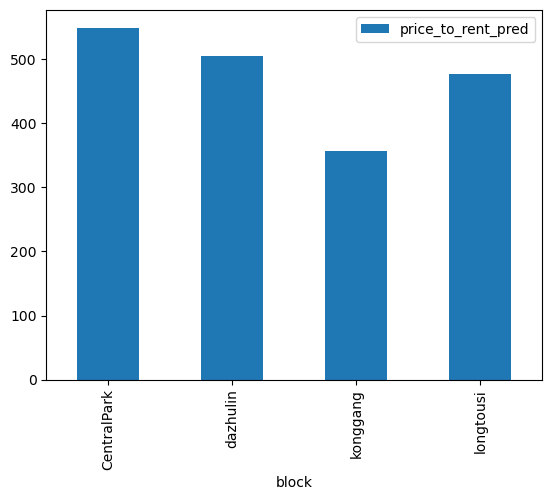

In [262]:
median_pred.plot.bar(x='block', y='price_to_rent_pred')
plt.show()

In [263]:
# === Step 9 计算 R² （5-fold CV）===
cv = KFold(n_splits=5, shuffle=True, random_state=1)
r2_price = cross_val_score(model_price, X_sale, y_sale, cv=cv, scoring='r2').mean()
r2_rent  = cross_val_score(model_rent,  X_rent, y_rent, cv=cv, scoring='r2').mean()
print("Model 1 R²:", r2_price)
print("Model 2 R²:", r2_rent)

Model 1 R²: 0.5328000892927702
Model 2 R²: 0.061059397140270755


## 3.2 Model Plus(HW3-5):Add features non-linearity and interaction

### HW3-5 Q2&Q3:Q2 Use model 1+ and model 2+ to predict price and rent for all data. Calculate price to rent ratio for each data.Q3 Figure C: Bar Plot the price to rent ratio for each block

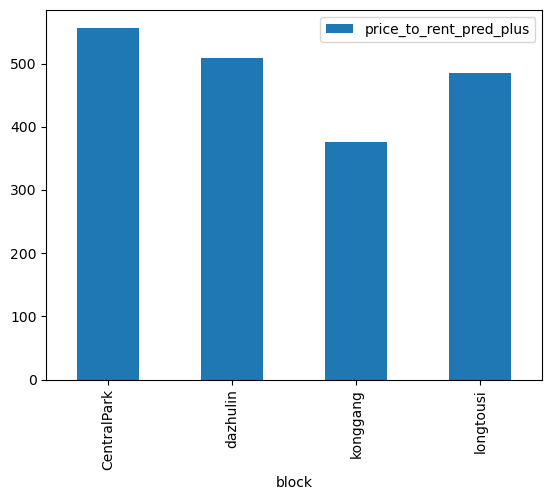

Model 1⁺ R²: 0.533917859683016
Model 2⁺ R²: 0.1293850139999248
Improvement:
Price ΔR² =  0.0011177703902457425
Rent ΔR²  =  0.06832561685965405


In [266]:
from sklearn.preprocessing import PolynomialFeatures

# === Step 1 多项式特征 + location哑变量 ===
poly = PolynomialFeatures(degree=2, include_bias=False)
preprocessor_plus = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['block']),
    ('poly', poly, ['Area'])
])

model_price_plus = Pipeline([
    ('pre', preprocessor_plus),
    ('lr', LinearRegression())
])

model_rent_plus = Pipeline([
    ('pre', preprocessor_plus),
    ('lr', LinearRegression())
])

# === Step 2 训练 ===
model_price_plus.fit(X_sale, y_sale)
model_rent_plus.fit(X_rent, y_rent)

# === Step 3 预测 ===
sale['price/m2_pred_plus'] = model_price_plus.predict(X_sale)
sale['rent/m2_pred_plus'] = model_rent_plus.predict(X_sale)
rental['rent/m2_pred_plus'] = model_rent_plus.predict(X_rent)
rental['price/m2_pred_plus'] = model_price_plus.predict(X_rent)

#为了尽可能准确，因此从sale爬来的数据保留原始sale price，采用模型预测的rent；从rent爬来的数据保留原始rent，采用模型预测的sale price
sale['price_to_rent_pred_plus'] = sale['price/m2'] / sale['rent/m2_pred_plus']
rental['price_to_rent_pred_plus'] = rental['price/m2_pred_plus'] / rental['rent/m2']
sale_median_pred_plus = sale[['block', 'price_to_rent_pred_plus']]
rental_median_pred_plus = rental[['block', 'price_to_rent_pred_plus']]
pred_plus = pd.concat([sale_median_pred_plus, rental_median_pred_plus], axis = 0)

median_pred_plus = pred_plus.groupby('block')['price_to_rent_pred_plus'].median().reset_index()



# === Step 5 画Figure C ===
median_pred_plus.plot.bar(x='block', y='price_to_rent_pred_plus')
plt.show()

# === Step 6 比较R² ===
r2_price_plus = cross_val_score(model_price_plus, X_sale, y_sale, cv=cv, scoring='r2').mean()
r2_rent_plus  = cross_val_score(model_rent_plus,  X_rent, y_rent, cv=cv, scoring='r2').mean()
print("Model 1⁺ R²:", r2_price_plus)
print("Model 2⁺ R²:", r2_rent_plus)
print("Improvement:")
print("Price ΔR² = ", r2_price_plus - r2_price)
print("Rent ΔR²  = ", r2_rent_plus - r2_rent)


### HW3-5 Q1 Which one has higher R2 and why?

###### 
由上述输出可知，Model 1+和Model 2+有更高的R方，其中Model 1+和Model 1的R方都大于Model 2+和Model 2的R方。但是Model 2+相比Model 2提升的幅度更大.
核心原因：租赁市场比买卖市场更复杂，而复杂模型正好能捕捉这种复杂性。​​
Q.​​为什么R²都提高了？​​
增强模型（Model 1+/2+）通过引入​​非线性和交互作用​​，能够捕捉数据中更复杂的模式，拟合能力更强，所以R²自然比简单线性模型（Model 1/2）高。
​Q.​为什么租金模型（Model 2）提升更大？​​
租金受短期、微观因素影响更大（如装修、房东急租、合租需求等），这些因素与地段、面积之间存在强烈的​​交互作用​​。
基础租金模型（Model 2）太简单，无法描述这种复杂关系，所以初始R²很低。
增强模型（Model 2+）一旦引入了交互项等功能，就能​​显著改善​​对租金规律的描述，因此R²提升幅度特别大。

### HW3-5 Q4 Compare the price to rent ratio from these three methods.Which one should you trust based on sample size

######
应该相信后两种，因为对于第一种，原始爬出来的租金数据和售价是不对应的（无法每一条数据都做price/rent），因此我们计算的方法是先对每个block的price和rent都取median，然后再相除。实际上price和rent都只有各一半的数据，先取median再相除。
而后两种方法中，我们引入了回归，为每一条数据都构建了price和rent，因此sample size是之前的两倍，可以各自先做比例相除再取median，更可信